# PyMCEF Quickstart tutorial
<br>
<br>
## Prerequisites
----------------------------
### Install
Please install package PyMCEF through either conda or pip:

<pre>
$ conda install -c hzzyyy pymcef

$ pip install pymcef
</pre>

conda packages are available on anaconda cloud for both python 2.7 and 3.5 on MacOS, Linux and Windows.

pip packages are available on pypi for both python 2.7 and 3.5 on MacOs, Linux and Windows.

This package is only available on 64 bits OS, in addition, C++11 runtime library is alse required. 

As result, this package will **NOT** work on Redhat EL6 with default configuration.

If you mainly work with Redhat you can either upgrade to EL7 or customize EL6 with C++11 support. 

### Efficient frontier
This package helps to find the efficient frontier based on (jointly) simulated returns of all investible assets.

Alternatively speaking, this package tries to solve this problem numerically:

> Given the joint distribution of the returns of all the investible assets, what should be the
> best choice of weights to assign on each assets, for all possible risk preferences.

Efficient frontier is the set of all 'best' choices of asset weights (a.k.a. portfolio) with all possible risk preferences.

Heuristically, the most risk-taking portfolio simply puts all weight on the asset with largest expected return. 

The most risk-averse portfolio is very diversified, with many positions hedging each other.

### Portfolio optimization

Each portfolio on the efficient frontier is obtained by solving the following optimization problem on the choice of weight vector $w$:

\begin{align*}
\underset{w}{\mathrm{argmin}}\quad & \mathrm{Risk}\left(w\right)-\lambda\cdot\mathrm{Reward}\left(w\right),\\
\mathrm{subject\ to}\quad & \sum_{i}w_{i} = 1,\\
 & \ \ \ \quad w_{i} > 0.
\end{align*}

The Lagrangian multiplier $\lambda$ here uniquely defines a risk preference and its corresponding solution. 
With $\lambda$ going to infinity the solution is the most risk-taking portfolio and with $\lambda$ being zero, the solution is the most risk-averse portfolio.

### Risk measures

We haven't defined the formulas for the risk and reward functions in the above optimization problem. Not surprisingly, the reward function is the just the expected return of the whole portfolio. Suppose the returns of all the asserts is the random vector: 

$$ Y = \{Y_i\}. $$ 

Then the reward function is simply:

\begin{eqnarray*}
\mathrm{Reward}\left(w\right) & = & \mathbb{E}\left[\sum_{i}w_{i}Y_{i}\right]\\
 & = & \mathbb{E}\left[X\right]\quad\mathrm{namely}
\end{eqnarray*}

The less obviously obtained risk function, formally known as risk measure, is a function of the portfolio return random variable $X$. 
In the Markowitz mean-variance model, the risk measure is the variance of $X$. In this PyMCEF, the following two more sophisticated risk measures are used:

####  Absolute Semideviation

\begin{eqnarray*}
\mathrm{Risk}\left(w\right) & = & \mathbb{E}\left[\max\left(\mathbb{E}X-X,\ 0\right)\right]\\
 & = & \mathbb{E}\left[\left(\mathbb{E}X-X\right)^{+}\right].
\end{eqnarray*}

#### Fixed-target under-performance

\begin{eqnarray*}
\mathrm{Risk}\left(w\right) & = & \mathbb{E}\left[\max\left(t-X,\ 0\right)\right]\\
 & = & \mathbb{E}\left[\left(t-X\right)^{+}\right],
\end{eqnarray*}

where $t$ is given target. The riskless return is a sensible choice. 

According to Post-modern portfolio theory (PMPT), these two risk measures are better than the variance because they are more consistent with the stochastic dominance rule. 

### Stochastic programming

The (joint) distribution of the returns of assets $\{Y_i\}$ can be parametric. A convenient
choice is to assume Normal or log Normal distribution. More complicated ways of
parameterizations for sure exist, and they lead to different optimization problems. 
In addition, with $\lambda$ varying as a positive real number, we face a continuum of
optimization problems.

Alternatively, we can work with the (finite) samples of $\{Y_i\}$.
In this case, we replace the expectation in the risk or reward function with statistical mean and work with a stochastic programming problem. 
PyMCEF is implemented in this way, and there is huge advantage in terms of flexibility. 
The input for PyMCEF is just Monte Carlo simulated returns, and no knowledge about the underlying distribution function is needed for this package to work. 
In Bayesian inference, it is a common practice to directly simulate the posterior predictive
distribution with Markov Chain Monte Carlo, where the posterior density function is known only 
up to a scaling factor. 
In another word, in practice, samples of distribution is more available than its corresponding parametric form.

Another benefit comes with the linearization of the problem. With slack variables, 
the constraint and objective function can be linearized such that the solution is valid for an interval of $\lambda$.
As a result, the (approximated) efficient frontier has only finite number of portfolios.
With stochastic programming, we solve an approximated problem whose solution is much easier to describe.

## One example
---------

We take the daily returns of US stocks in Russell 3000 from 2015-01-02 to 2017-01-04.
Each asset has 505 returns, which are treated as simulated daily returns.
The direct use of historical data are not Monter Carlo, however it is good enough to demonstrate how to use PyMCEF.
We can consider this predictive distribution as a largely over fitted model with not much predictive power.
However, this is good starting point for better models.

We removed stocks with prices lower than $5 (pink sheet) to avoid liquidity problem. The data is stored in this git repository and can be loaded into a pandas data frame:

In [1]:
import pandas as pd
returns = pd.read_json('data/Russel3k_return.json')

Instead of smoothing, we directly exclude those stocks with extremely large jump in prices (possibly erroneous).
Here, a gain or loss more than four times the 99% or 1% quantile is considered as extreme.

In [2]:
returns_filted = returns[(returns > returns.quantile(0.01) * 4) & \
                         (returns < returns.quantile(0.99) * 4)].dropna(axis=1)

After this filtering process, the number of remaining assets is:

In [3]:
len(returns_filted.columns)

2083

Next we use this return data as both training set and validation set to construct an efficient frontier with PyMCEF.
The risk measure is not specified and the default absolute semi-deviation is used.

In [4]:
from time import time
import numpy as np
from pymcef import SimpleEFp
tic = time()
frt = SimpleEFp(training_set=np.transpose(returns_filted.values),\
                validation_set=np.transpose(returns_filted.values),\
                asset_names=returns_filted.columns)
print(time() - tic)

Sample efficient frontier contains 2292 portfolios
Max Sharpe portfolio is the 1092th
42.4827349186


As we can see, the full efficient frontier is obtained in less than one minute. Let's take a look at the efficient frontier:

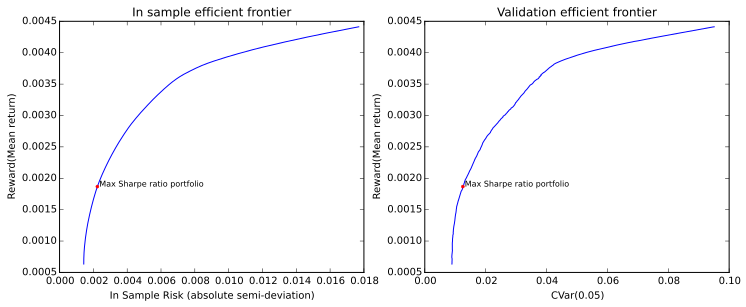

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig_ef = frt.plot_ef()

The performances of all portfolio is also visualized:

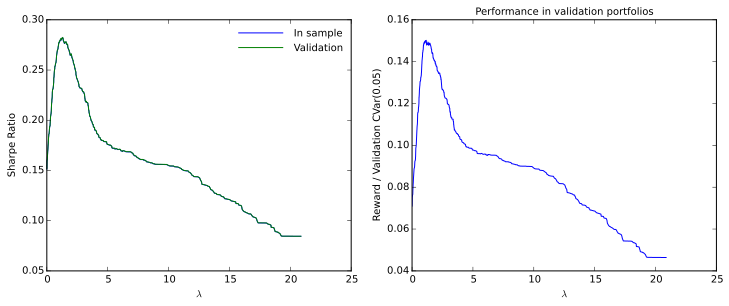

In [6]:
fig_pf = frt.plot_performance()

And how the weights vary with different values of $\lambda$:

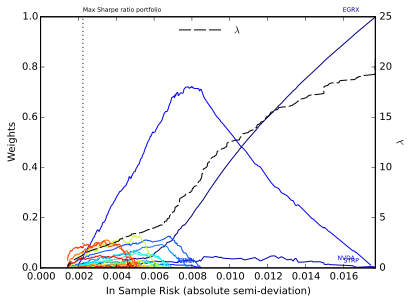

In [7]:
fig_ws = frt.plot_weights()

All the weights are stored in the instance of SimpleEFp.
The first one is the most risk-seeking: 

In [8]:
from __future__ import print_function
prt0 = frt.frontier_in_sample[0]
for k, v in prt0['weight'].items():
    print(frt.asset_names[k], v)

EGRX 1.0


Starting from the second portfolio, there are more than one assets:

In [9]:
prt1 = frt.frontier_in_sample[1]
for k, v in prt1['weight'].items():
    print(frt.asset_names[k], v)

STRP 0.00148507437883
EGRX 0.998514925621


In [10]:
prt3 = frt.frontier_in_sample[3]
for k, v in prt3['weight'].items():
    print(frt.asset_names[k], v)

STRP 0.00512779539909
EGRX 0.983506565427
NVDA 0.0113656391735


And the number of assets contained in the most risk-averse portfolio is:

In [11]:
print(len(frt.frontier_in_sample[-1]['weight']))

61


frt.frontier_in_sample stores all the main results of the efficient frontier construction,
the user can conduct their own studies with all the weights in it. 